In [1]:
# imports, parameters, environment, etc.
import torch
import torch.nn as nn
from utilities.ogbench_utilities import *
from decision_diffuser import DecisionDiffuserTrainConfig
from janner_diffuser import JannerDiffuserTrainConfig
from decision_diffuser import eval_model as dd_eval
from janner_diffuser import eval_model as janner_eval
from utilities.cleandiffuser.invdynamic import MlpInvDynamic
from utilities.cleandiffuser.diffusion import ContinuousDiffusionSDE
from utilities.cleandiffuser.diffusion import DiscreteDiffusionSDE
from utilities.cleandiffuser.nn_diffusion import JannerUNet1d
from utilities.cleandiffuser.nn_condition import MLPCondition
from utilities.flatland_plus_environment import make_envs_and_datasets_flatland
import matplotlib.pyplot as plt
env = 'flatland2'
memory = 1
horizon = 128
num_envs = 1
num_episodes = 1
temperature = 0.5
n_exec_steps = 120
render = True
# if doing flatland stuff
flatland = True
n_dims = 2

def show_trajectory_janner(agent,invdyn,envs,config,start_idx,goal_idx):
# ---------------------- Inference ----------------------


    agent.eval()
    # sets up the inpainting mask for the generation process if needed
    #print(agent.fix_mask.shape)
    #print(agent.fix_mask)
    agent.fix_mask = agent.fix_mask * 0.0
    # sets up the inpainting mask for the generation process if needed
    fix_mask = agent.fix_mask
    fix_mask[:,0, :] = 1. # for the starting/current state
    if config.inpaint:
        fix_mask[:,-5:, :] = 1.# for ending state
    agent.fix_mask = fix_mask 

    obs_dim = envs.single_observation_space.shape[0]
    prior = torch.zeros((config.num_envs, config.horizon, obs_dim), device=config.device) # size (num_envs, config.horizon, obs_dim)
    envs.call('set_start_goal_idx',start_idx=start_idx,goal_idx=goal_idx)
    obs, info = envs.reset(options={})
    goal = info['goal'][0]
    t = 0.
    completed = np.zeros((config.num_envs)).astype(bool) # - per-env completion
    goals = info['goal'] # Goal state - shape (n_envs, obs_dim)
    truncated = False
    state_history = [obs]

    # sample trajectories``
    # inpaints history to beginning of generated trajectory
    history_len = min(len(state_history),config.memory)
    #print(np.array(state_history)[-history_len:].shape)
    prior[:, :history_len, :obs_dim] = torch.tensor(np.transpose(np.array(state_history[-history_len:]), (1,0,2)),device=config.device) # inpaints start state at beginning of trajectory
    # modifies agent mask to account for history
    fix_mask = agent.fix_mask 
    fix_mask[:,:history_len, :] = 1. 
    agent.fix_mask = fix_mask

    # inpaints goal state if desired
    if config.inpaint:
        prior[:, -5:, :obs_dim] = torch.tensor(goals,device=config.device) # inpaints goal state at end of trajectory

    #print(agent.fix_mask[:,-5:,:])
    #print(prior)
    traj, log = agent.sample(
        prior,
        solver='ddpm',
        n_samples=config.num_envs,
        sample_steps=config.sampling_steps,
        use_ema=config.use_ema, w_cg=config.w_cg, temperature=config.temperature)
    traj = traj.cpu().numpy()
    #print(len(traj[0]))
    print(traj[:,-5:,:])
    plt.scatter(traj[0,:,0],traj[0,:,1],c=range(len(traj[0])),s=5)
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)
    plt.scatter(goal[0],goal[1],c='red',label='goal')
    plt.legend()
    plt.colorbar()
    return traj
def show_trajectory_dd(agent,invdyn,envs,config,start_idx,goal_idx):
# ---------------------- Inference ----------------------


    agent.eval()
    # sets up the inpainting mask for the generation process if needed
    if config.inpaint:
        fix_mask = agent.fix_mask # should have start state already masked from training
        fix_mask[:,-5:, :] = 1.
        agent.fix_mask = fix_mask # for ending state

    obs_dim = envs.single_observation_space.shape[0]
    prior = torch.zeros((config.num_envs, config.horizon, obs_dim), device=config.device) # size (num_envs, config.horizon, obs_dim)

    envs.call('set_start_goal_idx',start_idx=start_idx,goal_idx=goal_idx)
    obs, info = envs.reset(options={})  
    t = 0.
    completed = np.zeros((config.num_envs)).astype(bool) # - per-env completion
    goals = torch.tensor(info['goal'],device=config.device).to(torch.float) # shape (n_envs, obs_dim)
    condition = goals # shapes should line up 
    truncated = False
    state_history = [obs]

    # sample trajectories
    # inpaints history to beginning of generated trajectory
    history_len = min(len(state_history),config.memory)
    #print(np.array(state_history)[-history_len:].shape)
    prior[:, :history_len, :obs_dim] = torch.tensor(np.transpose(np.array(state_history[-history_len:]), (1,0,2)),device=config.device) # inpaints start state at beginning of trajectory
    # modifies agent mask to account for history
    fix_mask = agent.fix_mask 
    fix_mask[:,:history_len, :] = 1. 
    agent.fix_mask = fix_mask

    # inpaints goal state if desired
    if config.inpaint:
        prior[:, -5:, :obs_dim] = torch.tensor(goals,device=config.device) # inpaints goal state at end of trajectory

    traj, log = agent.sample(
            prior, solver=config.solver,
            n_samples=config.num_envs, sample_steps=config.sampling_steps, use_ema=config.use_ema,
            condition_cfg=condition, w_cfg=config.w_cfg, temperature=config.temperature)
    traj = traj.cpu().numpy()
    print(len(traj[0]))
    plt.scatter(traj[0,:,0],traj[0,:,1],c=range(len(traj[0])),s=5)
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)
    plt.colorbar()
    goal = info['goal'][0]
    plt.scatter(goal[0],goal[1],c='red',label='goal')
    plt.legend()
    return traj

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Environment Info ====
Name: flatland2
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

Avg. Completion: 0.0


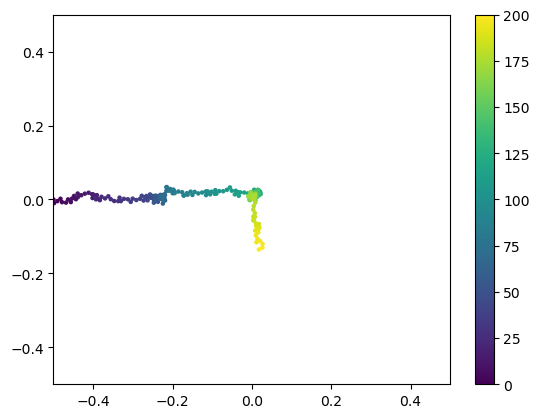

In [2]:
### eval for diffuser w/inpainting

# loads config, modifies to work w/given parameters
config = JannerDiffuserTrainConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = True
config.flatland = flatland
config.n_dims = n_dims

# loads environment
envs = make_envs_and_datasets_flatland(n_dims=config.n_dims,num_envs = config.num_envs,env_only=True)
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
#invdyn.load(config.invdyn_path)
invdyn.eval()

# loads agent 
# --------------- Network Architecture -----------------# 
nn_diffusion = JannerUNet1d(
        obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
        timestep_emb_type="positional", attention=False, kernel_size=5)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim)) 
fix_mask[0, :] = 1. # for the starting/current state
loss_weight = torch.ones((config.horizon, obs_dim))

# --------------- difuse --------------------
agent = DiscreteDiffusionSDE(
        nn_diffusion, None,
        fix_mask=fix_mask, loss_weight=loss_weight, classifier=None, ema_rate=config.ema_rate,
        device=config.device, diffusion_steps=config.diffusion_steps, predict_noise=config.predict_noise)
agent.load('trained_models/JannerInpaint-h128-flatland2.pt')

# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.reset()
avg_completion,trajectories = janner_eval(agent,invdyn,envs,config,give_trajectory=True)
#traj = show_trajectory_janner(agent,invdyn,envs,config)
print('Avg. Completion:',avg_completion)
#print(traj)  
plt.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5)
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.colorbar()

[[[ 0.  -0.5]
  [ 0.  -0.5]
  [ 0.  -0.5]
  [ 0.  -0.5]
  [ 0.  -0.5]]]


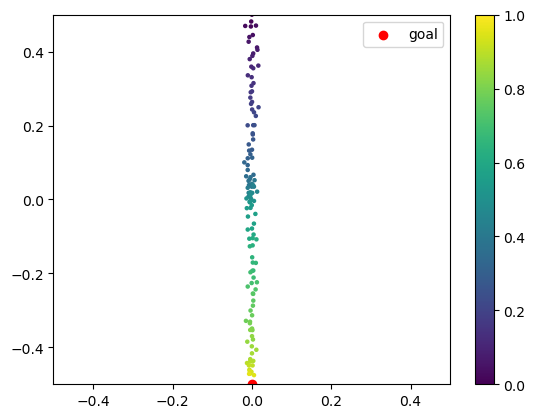

In [32]:
traj = show_trajectory_janner(agent,invdyn,envs,config,start_idx=3,goal_idx=2)

==== Environment Info ====
Name: flatland2
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

Avg. Completion: 0.0
(201, 1, 2)
0.47216897907303046
[[-0.16014259  0.05581772]]
[0.  0.5]


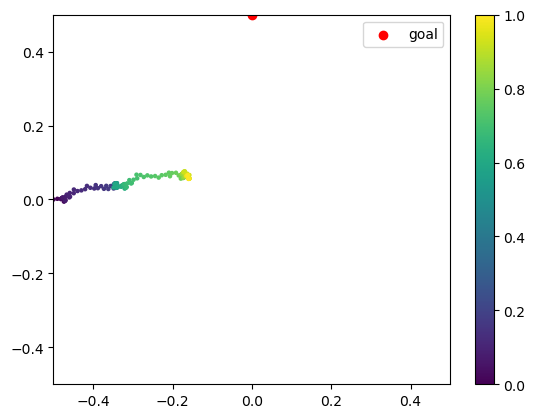

In [14]:
### eval for decision diffuser base 

# loads config, modifies to work w/given parameters
config = DecisionDiffuserTrainConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.temperature = temperature
config.n_exec_steps = n_exec_steps
config.env = env
config.inpaint = False
config.flatland = flatland
config.n_dims = n_dims


# loads environment
envs = make_envs_and_datasets_flatland(n_dims=config.n_dims,num_envs = config.num_envs,env_only=True)
envs.tolerance = 0.1
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
#invdyn.load(config.invdyn_path)
invdyn.eval()

# loads agent 
# --------------- Network Architecture -----------------# --------------- Network Architecture -----------------
nn_diffusion = JannerUNet1d(
    obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
    timestep_emb_type="positional", attention=False, kernel_size=5)
nn_condition = MLPCondition(
    in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim))
fix_mask[0] = 1. # for starting state
if config.inpaint:
    fix_mask[-1] = 1. # for ending goal state
loss_weight = torch.ones((config.horizon, obs_dim))
loss_weight[1] = config.next_obs_loss_weight

# --------------- Diffusion Model with Classifier-Free Guidance --------------------
agent = ContinuousDiffusionSDE(
    nn_diffusion, nn_condition,
    fix_mask=fix_mask, loss_weight=loss_weight, ema_rate=config.ema_rate,
    device=config.device, predict_noise=config.predict_noise, noise_schedule="linear")
agent.load('trained_models/CFGDiffuser-h16-flatland2.pt')

# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.call('set_start_goal_idx',start_idx=0,goal_idx=3)
_, info = envs.reset(options={})

avg_completion,trajectories = dd_eval(agent,invdyn,envs,config,give_trajectory=True)
#traj = show_trajectory_janner(agent,invdyn,envs,config)
print('Avg. Completion:',avg_completion)
#print(traj)  
plt.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5)
goal = info['goal'][0]
plt.scatter(goal[0],goal[1],c='red',label='goal')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.colorbar()
plt.legend()
print(trajectories[0].shape)
print(np.linalg.norm(trajectories[0][-1,:,:]-goal))
print(trajectories[0][-1,:,:])
print(goal)

128


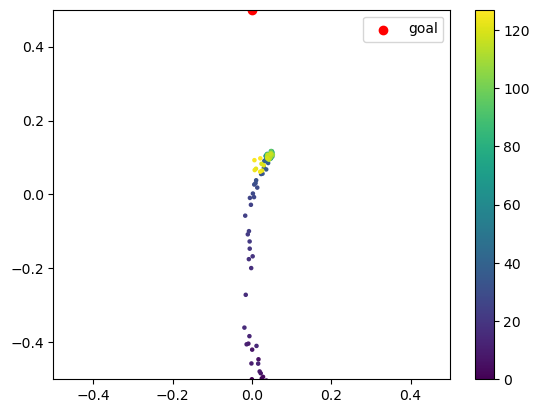

In [23]:
traj = show_trajectory_dd(agent,invdyn,envs,config,start_idx=2,goal_idx=3)

/root/generative-stitching/goal_stitching/utilities/cleandiffuser/diffusion/basic.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_loc

==== Environment Info ====
Name: flatland2
Obs Space: 2
Act Space: 2
==== Running Eval ====


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]

Avg. Completion: 0.0
(201, 1, 2)
0.5430958559108447
[[-0.04107107  0.04154065]]
[ 0.  -0.5]


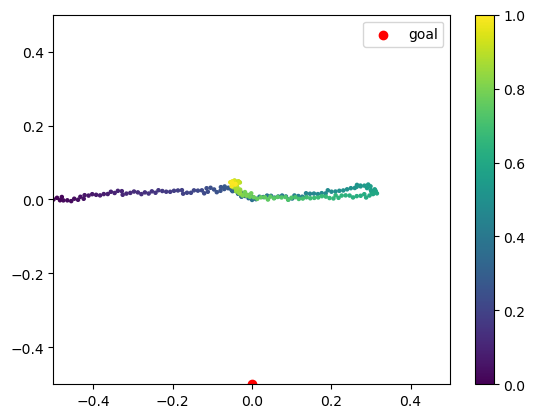

In [29]:
### eval for conditioned diffuser

# loads config, modifies to work w/given parameters
config = DecisionDiffuserTrainConfig()
config.memory = memory
config.horizon = horizon
config.num_envs = num_envs
config.num_episodes = num_episodes
config.temperature = temperature
config.n_exec_steps = n_exec_steps
config.env = env
config.w_cfg = 0.0

config.inpaint = False
config.flatland = flatland


# loads environment
envs = make_envs_and_datasets_flatland(n_dims=config.n_dims,num_envs = config.num_envs,env_only=True)
envs.tolerance = 0.1
obs_dim, act_dim = envs.single_observation_space.shape[0], envs.single_action_space.shape[0]

# loads inverse dynamics
invdyn = MlpInvDynamic(obs_dim, act_dim, 512, nn.Tanh(), {"lr": 2e-4}, device=config.device)
#invdyn.load(config.invdyn_path)
invdyn.eval()

# loads agent 
# --------------- Network Architecture -----------------# --------------- Network Architecture -----------------
nn_diffusion = JannerUNet1d(
    obs_dim, model_dim=config.model_dim, emb_dim=config.model_dim, dim_mult=[1, 2, 2, 2],
    timestep_emb_type="positional", attention=False, kernel_size=5)
nn_condition = MLPCondition(
    in_dim=obs_dim, out_dim=config.emb_dim, hidden_dims=[config.emb_dim, ], act=nn.SiLU(), dropout=config.label_dropout)


# ----------------- Masking -------------------
# NOTE - not sure what any of this does (should figure out!)
fix_mask = torch.zeros((config.horizon, obs_dim))
fix_mask[0] = 1. # for starting state
if config.inpaint:
    fix_mask[-1] = 1. # for ending goal state
loss_weight = torch.ones((config.horizon, obs_dim))
loss_weight[1] = config.next_obs_loss_weight

# --------------- Diffusion Model with Classifier-Free Guidance --------------------
agent = ContinuousDiffusionSDE(
    nn_diffusion, nn_condition,
    fix_mask=fix_mask, loss_weight=loss_weight, ema_rate=config.ema_rate,
    device=config.device, predict_noise=config.predict_noise, noise_schedule="linear")
agent.load('trained_models/CFGDiffuser-h128-flatland2.pt')

# Environment info 
print('==== Environment Info ====')
print('Name:',config.env)
print('Obs Space:',obs_dim)
print('Act Space:',act_dim)
# main evaluation loop
print('==== Running Eval ====')
envs.call('set_start_goal_idx',start_idx=0,goal_idx=2)
_, info = envs.reset(options={})

avg_completion,trajectories = dd_eval(agent,invdyn,envs,config,give_trajectory=True)
#traj = show_trajectory_janner(agent,invdyn,envs,config)
print('Avg. Completion:',avg_completion)
#print(traj)  
plt.scatter(trajectories[0][:,:,0],trajectories[0][:,:,1],c=range(len(trajectories[0])),s=5)
goal = info['goal'][0]
plt.scatter(goal[0],goal[1],c='red',label='goal')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.colorbar()
plt.legend()
print(trajectories[0].shape)
print(np.linalg.norm(trajectories[0][-1,:,:]-goal))
print(trajectories[0][-1,:,:])
print(goal)

128


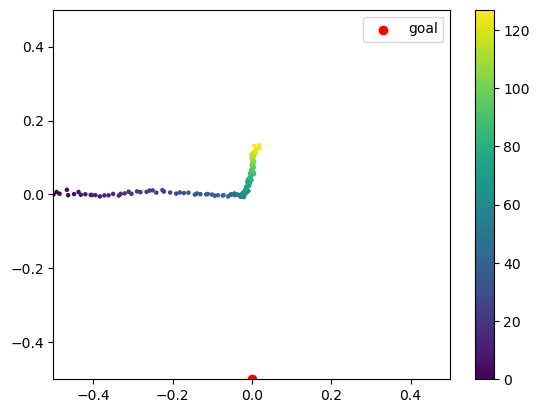

In [38]:
traj = show_trajectory_dd(agent,invdyn,envs,config,start_idx=0,goal_idx=2)